In [1]:
# !pip install matplotlib
# !pip install pandas
# !pip install numpy
# !pip install tensorboard
# !pip install tqdm

# resnet

1.Introduction

ResNet, short for Residual Network, is a convolutional neural network introduced by Microsoft Research in 2015. The main innovation of ResNet is the use of residual connections, which allows the network to learn deeper architectures than traditional CNNs.

A residual connection is a shortcut connection that skips one or more layers and connects the input of one layer directly to the output of a layer further down in the network. This allows the network to learn the residual mapping between the input and output of the skipped layer rather than the mapping itself.

The original ResNet architecture, called ResNet-50, had 50 layers and was trained on the ImageNet dataset, achieving state-of-the-art results at the time of release. Since then, several variants of the ResNet architecture have been proposed, such as ResNet-101, ResNet-152, and ResNet-200, with more layers, and ResNet-18, with a smaller version of 18 layers.

ResNet has been widely used in many computer vision tasks, such as image classification, object detection, semantic segmentation, etc. It is also a popular choice for transfer learning, where pre-trained ResNet models can be fine-tuned for different tasks with relatively small datasets.



2.Detail

Next, I will introduce in detail what the code of each box does

import and add name

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torchvision
import torchvision.models as models
import os
import numpy as np
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
from tqdm import tqdm
from net import *
from PIL import Image


import torch.nn.functional as F
import torch.nn as nn
from util import get_transform, get_acc


The SummaryWriter class is used to write TensorFlow summary data to a specified directory, which can be visualized in TensorBoard. The batch size, learning rate, weight decay and number of epochs are hyperparameters that control the training process of the model.

In [3]:
writer = SummaryWriter ('tf_logs_exp') 
batch_Size = 32
learning_rate = 3e-4
weight_decay = 1e-3
num_epoch = 20


 Define the model used

In [4]:
#model = get_resnext() 
#model = get_resnet()
model = get_resnet18()

#model = get_resnet18_1()

Define the name of the training weights of the saved model

In [5]:
#model_path = r'model_save/resnet.pth' 
# model_path = r'model_save/resnext.pth'
model_path = r'model_save/resnet18.pth'

In [6]:
get_resnet18

<function net.get_resnet18()>

Use gpu if not can use cpu.
 using a GPU with CUDA is generally better for machine learning and deep learning tasks because it allows for faster processing of large amounts of data in parallel, and it is also more versatile and easier to use than other GPU programming frameworks.

In [7]:
def get_device():
    return 'cuda' if torch.cuda.is_available () else 'cpu'

Check if gpu is used correctly

In [8]:
device = get_device ()
print (device)

cuda


Import the correct address for train and valid

In [9]:
model = model.to (device)
train_path = r'dataset/train'
val_path = r'dataset/valid'

Do a transform on the data

In [10]:
# transforms_train = transforms.Compose (
#     [
#         transforms.Resize ([224, 224]),
#         transforms.ToTensor ()
#     ])

# transforms_vaild = transforms.Compose (
#     [
#         transforms.Resize ([224, 224]),
#         transforms.ToTensor ()
#     ])

train_dataset = torchvision.datasets.ImageFolder (root=train_path, transform=get_transform())
val_dataset = torchvision.datasets.ImageFolder (root=val_path, transform=get_transform())

print ('The dataset corresponding labels are:{}'.format (train_dataset.class_to_idx))

The dataset corresponding labels are:{'Albedo': 0, 'CC': 1, 'CuChulainn': 2, 'Gilgamesh': 3, 'Sesshomaru': 4}


In [11]:
train_loader = DataLoader (dataset=train_dataset, batch_size=batch_Size, shuffle=True, num_workers=2)
val_loader = DataLoader (dataset=val_dataset, batch_size=batch_Size, shuffle=True, num_workers=2)
print(train_loader,val_loader)

<torch.utils.data.dataloader.DataLoader object at 0x000001B8AD969ED0> <torch.utils.data.dataloader.DataLoader object at 0x000001B8AD969DB0>


In [12]:
len(val_loader)*32

384

In [13]:
batch_images, batch_labels=next(iter(train_loader))

In [14]:
print(f"Image shape: {batch_images.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {batch_labels.shape}")

Image shape: torch.Size([32, 3, 224, 224]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([32])


In [15]:
class_name=train_dataset.classes

In [16]:
class_name

['Albedo', 'CC', 'CuChulainn', 'Gilgamesh', 'Sesshomaru']

C:\Users\21083\AppData\Local\Temp\ipykernel_36412\2439748209.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  plot_img=torch.tensor(data=batch_images[i].permute(1, 2, 0))


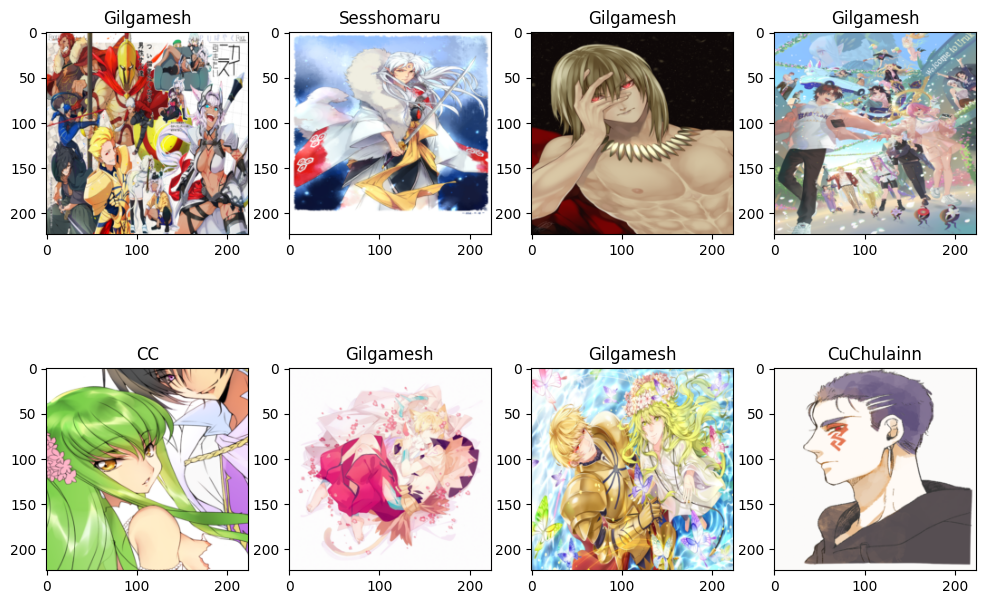

In [17]:
plt.figure(figsize=(12,8))

for i in range(8):
    plot_img=torch.tensor(data=batch_images[i].permute(1, 2, 0))
    plt.subplot(2,4,i+1)
    plt.title(class_name[batch_labels[i]])
    plt.imshow(plot_img)     

In [18]:
# 定义交叉熵损失函数，adam优化器，cos余弦学习率调整
criterion = nn.CrossEntropyLoss ()
optimizer = torch.optim.Adam (model.parameters (), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR (optimizer, T_max=10, eta_min=0, last_epoch=-1)

n_epochs = num_epoch

best_acc = 0.0

train_acc_list = []
train_loss_list = []

valid_loss_list = []
valid_acc_list = []


In [19]:
# 开始周期训练
for epoch in tqdm(range(n_epochs)):
    # ---------- Training ----------

    model.train ()
    train_loss = []
    train_accs = []

    i = 0

    for batch in tqdm (train_loader):

        imgs, labels = batch
        imgs = imgs.to (device)
        labels = labels.to (device)
        logits = model (imgs)
        # 计算loss
        loss = criterion (logits, labels)

        # 网络更新
        optimizer.zero_grad ()
        loss.backward ()
        optimizer.step ()
        scheduler.step ()

        #if (i % 500 == 0):
            #print ("learning_rate:", scheduler.get_last_lr ()[0])
       # i = i + 1

        acc = (logits.argmax (dim=-1) == labels).float ().mean ()

        train_loss.append (loss.item ())
        train_accs.append (acc.item ())

    train_loss = sum (train_loss) / len (train_loss)
    train_acc = sum (train_accs) / len (train_accs)

    print (f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")

    train_acc_list.append (train_acc)
    train_loss_list.append (train_loss)
    

    # 记录到tensorboard
    writer.add_scalar ('Train Loss ', train_acc, epoch)
    writer.add_scalar ('Train Accuracy ', train_loss, epoch)

    # ---------- Validation ----------
    model.eval ()

    valid_loss = []
    valid_accs = []

    for batch in tqdm (val_loader):
        imgs, labels = batch

        with torch.no_grad ():
            logits = model (imgs.to (device))

        loss = criterion (logits, labels.to (device))

        acc = (logits.argmax (dim=-1) == labels.to (device)).float ().mean ()

        valid_loss.append (loss.item ())
        valid_accs.append (acc)

    valid_loss = sum (valid_loss) / len (valid_loss)
    valid_acc = sum (valid_accs) / len (valid_accs)

    print (f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")
    valid_loss_list.append (valid_loss)
    valid_acc_list.append (valid_acc)

    # 保留在验证集上最好的模型
    if valid_acc > best_acc:
        best_acc = valid_acc
        torch.save (model.state_dict (), model_path)
        print ('saving model with acc {:.3f}'.format (best_acc))

    writer.add_scalar ('Valid Loss ', valid_acc, epoch)
    writer.add_scalar ('Valid Accuracy ', valid_loss, epoch)


100%|██████████| 57/57 [01:33<00:00,  1.65s/it]


[ Train | 001/020 ] loss = 1.19429, acc = 0.54447


  5%|▌         | 1/20 [01:52<35:43, 112.80s/it]

[ Valid | 001/020 ] loss = 0.97302, acc = 0.67569
saving model with acc 0.676


100%|██████████| 57/57 [01:08<00:00,  1.21s/it]


[ Train | 002/020 ] loss = 0.95863, acc = 0.63999


 10%|█         | 2/20 [03:16<28:40, 95.59s/it] 

[ Valid | 002/020 ] loss = 1.00861, acc = 0.64184


100%|██████████| 57/57 [01:13<00:00,  1.29s/it]


[ Train | 003/020 ] loss = 0.87898, acc = 0.67099


 15%|█▌        | 3/20 [04:45<26:15, 92.65s/it]

[ Valid | 003/020 ] loss = 1.12603, acc = 0.62587


100%|██████████| 57/57 [01:10<00:00,  1.23s/it]


[ Train | 004/020 ] loss = 0.83693, acc = 0.69749


 20%|██        | 4/20 [06:10<23:55, 89.70s/it]

[ Valid | 004/020 ] loss = 1.07242, acc = 0.56719


100%|██████████| 57/57 [01:11<00:00,  1.26s/it]


[ Train | 005/020 ] loss = 0.82670, acc = 0.69974


 25%|██▌       | 5/20 [07:38<22:14, 88.94s/it]

[ Valid | 005/020 ] loss = 1.93433, acc = 0.51649


100%|██████████| 57/57 [01:12<00:00,  1.27s/it]


[ Train | 006/020 ] loss = 0.75330, acc = 0.72868


 30%|███       | 6/20 [09:05<20:37, 88.39s/it]

[ Valid | 006/020 ] loss = 1.23666, acc = 0.51649


100%|██████████| 57/57 [01:15<00:00,  1.33s/it]


[ Train | 007/020 ] loss = 0.69999, acc = 0.74708


 35%|███▌      | 7/20 [10:35<19:16, 88.94s/it]

[ Valid | 007/020 ] loss = 0.98663, acc = 0.65972


100%|██████████| 57/57 [01:01<00:00,  1.08s/it]


[ Train | 008/020 ] loss = 0.66005, acc = 0.76200


 40%|████      | 8/20 [11:49<16:51, 84.27s/it]

[ Valid | 008/020 ] loss = 1.01583, acc = 0.67830
saving model with acc 0.678


100%|██████████| 57/57 [01:01<00:00,  1.08s/it]


[ Train | 009/020 ] loss = 0.58105, acc = 0.78667


 45%|████▌     | 9/20 [13:03<14:51, 81.07s/it]

[ Valid | 009/020 ] loss = 0.81004, acc = 0.74375
saving model with acc 0.744


100%|██████████| 57/57 [01:01<00:00,  1.07s/it]


[ Train | 010/020 ] loss = 0.46521, acc = 0.83571


 50%|█████     | 10/20 [14:19<13:12, 79.23s/it]

[ Valid | 010/020 ] loss = 0.83486, acc = 0.69392


100%|██████████| 57/57 [01:00<00:00,  1.05s/it]


[ Train | 011/020 ] loss = 0.39301, acc = 0.86544


 55%|█████▌    | 11/20 [15:32<11:35, 77.31s/it]

[ Valid | 011/020 ] loss = 0.94322, acc = 0.66944


100%|██████████| 57/57 [01:02<00:00,  1.10s/it]


[ Train | 012/020 ] loss = 0.30501, acc = 0.89827


 60%|██████    | 12/20 [16:47<10:13, 76.74s/it]

[ Valid | 012/020 ] loss = 2.05026, acc = 0.46667


100%|██████████| 57/57 [00:58<00:00,  1.03s/it]


[ Train | 013/020 ] loss = 0.23779, acc = 0.92392


 65%|██████▌   | 13/20 [17:58<08:44, 74.94s/it]

[ Valid | 013/020 ] loss = 1.73204, acc = 0.58160


100%|██████████| 57/57 [01:00<00:00,  1.06s/it]


[ Train | 014/020 ] loss = 0.19293, acc = 0.92928


 70%|███████   | 14/20 [19:11<07:26, 74.42s/it]

[ Valid | 014/020 ] loss = 0.87598, acc = 0.75677
saving model with acc 0.757


100%|██████████| 57/57 [00:59<00:00,  1.05s/it]


[ Train | 015/020 ] loss = 0.12023, acc = 0.96327


 75%|███████▌  | 15/20 [20:24<06:09, 73.90s/it]

[ Valid | 015/020 ] loss = 0.97156, acc = 0.72778


100%|██████████| 57/57 [00:58<00:00,  1.02s/it]


[ Train | 016/020 ] loss = 0.06814, acc = 0.97996


 80%|████████  | 16/20 [21:35<04:52, 73.02s/it]

[ Valid | 016/020 ] loss = 1.13635, acc = 0.71962


100%|██████████| 57/57 [01:00<00:00,  1.06s/it]


[ Train | 017/020 ] loss = 0.08640, acc = 0.97600


 85%|████████▌ | 17/20 [22:47<03:38, 72.91s/it]

[ Valid | 017/020 ] loss = 1.45145, acc = 0.72847


100%|██████████| 57/57 [01:00<00:00,  1.07s/it]


[ Train | 018/020 ] loss = 0.08585, acc = 0.97533


 90%|█████████ | 18/20 [24:00<02:25, 72.97s/it]

[ Valid | 018/020 ] loss = 1.55351, acc = 0.60920


100%|██████████| 57/57 [01:00<00:00,  1.07s/it]


[ Train | 019/020 ] loss = 0.04596, acc = 0.98684


 95%|█████████▌| 19/20 [25:14<01:13, 73.13s/it]

[ Valid | 019/020 ] loss = 1.00172, acc = 0.74045


100%|██████████| 57/57 [01:01<00:00,  1.07s/it]


[ Train | 020/020 ] loss = 0.04383, acc = 0.98465


100%|██████████| 20/20 [26:28<00:00, 79.42s/it]

[ Valid | 020/020 ] loss = 1.20107, acc = 0.67569


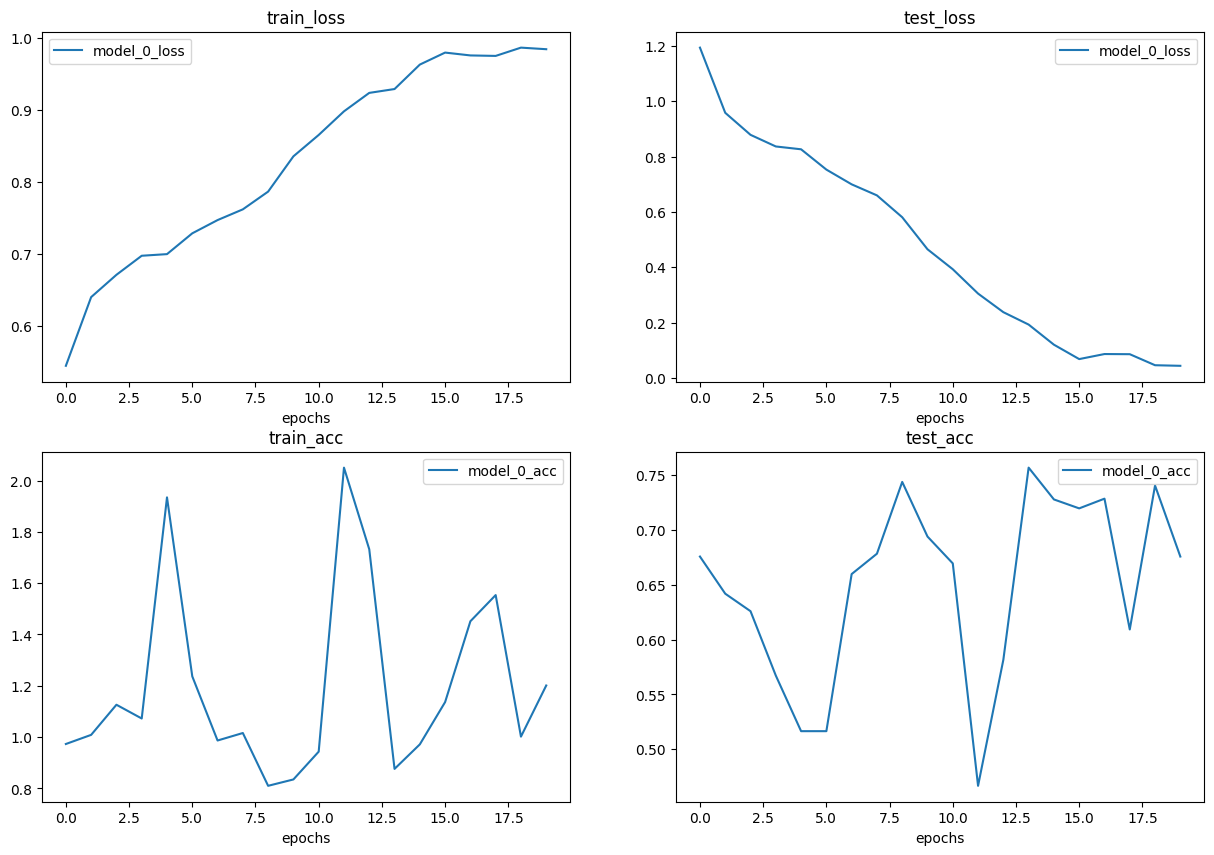

In [20]:
# ------ Complete subplot functions in the following lines -------
plt.figure(figsize=(15, 10))

# Plot train loss with label, title, legend
plt.subplot(2, 2, 1)
plt.plot(train_acc_list,label='model_0_loss')  
plt.title('train_loss')
plt.xlabel('epochs')
plt.legend()

# Plot test loss
plt.subplot(2, 2, 2)
plt.plot(train_loss_list,label='model_0_loss')  
plt.title('test_loss')
plt.xlabel('epochs')
plt.legend()

# Plot train accuracy
plt.subplot(2, 2, 3)
plt.plot(valid_loss_list,label='model_0_acc') 
plt.title('train_acc')
plt.xlabel('epochs')
plt.legend()

valid_accuracy_list=[]
for i in valid_acc_list:
    valid_accuracy_list.append(i.tolist())
    
# Plot test accuracy
plt.subplot(2, 2, 4)
plt.plot(valid_accuracy_list,label='model_0_acc')   

plt.title('test_acc')
plt.xlabel('epochs')
plt.legend()


In [21]:
valid_accuracy_list=[]
for i in valid_acc_list:
    valid_accuracy_list.append(i.tolist())

In [22]:
valid_accuracy_list

[0.675694465637207,
 0.6418403387069702,
 0.6258680820465088,
 0.5671875476837158,
 0.5164930820465088,
 0.5164930820465088,
 0.6597222089767456,
 0.6782986521720886,
 0.7437500357627869,
 0.6939236521720886,
 0.6694445013999939,
 0.46666666865348816,
 0.5815972089767456,
 0.7567708492279053,
 0.7277778387069702,
 0.7196180820465088,
 0.7284722328186035,
 0.6092014312744141,
 0.740451455116272,
 0.675694465637207]

In [23]:
# 建立模型并读取训练好的权重

#model = get_resnext() # 定义使用的模型
#model = get_resnet()
model = get_resnet18()
#model_path = r'model_save/resnet.pth' #定义保存模型训练权重的名称
# model_path = r'model_save/resnext.pth'
model_path = r'model_save/resnet18.pth'


In [24]:
test_path = r'dataset/test'


test_dataset = torchvision.datasets.ImageFolder (root=test_path, transform=get_transform())

test_loader = DataLoader (dataset=test_dataset, batch_size=32, shuffle=True)

In [25]:
num_ftrs = model.fc.in_features
model.fc = nn.Linear (num_ftrs, 5)
model.load_state_dict (torch.load (model_path))
model = model.to (device)

criterion = nn.CrossEntropyLoss ()

model.eval ()
test_loss = []
test_accs = []


In [26]:
test_acc = get_acc(model, test_loader, criterion)
print (f"Test  acc = {test_acc:.5f}")

100%|██████████| 12/12 [00:19<00:00,  1.64s/it]

Test  acc = 0.69416


In [27]:
# 对单张图像进行预测
def model_test(model, img_path):
    device = 'cuda'
    data_transform = transforms.Compose ([
        transforms.Resize ((224, 224)),
        transforms.ToTensor (),
    ])

    img = Image.open (img_path)
    img = data_transform (img)
    # 增加一维batch
    img = torch.unsqueeze (img, dim=0)

    model.eval ()
    with torch.no_grad ():
        output = model (img.to (device))
        number = torch.argmax (output.to ('cpu')[0]).numpy ().item ()
    #         print(answer)
    return number



In [28]:
if __name__ == '__main__':
    # 建立模型并读取训练好的权重
    model = get_resnet18 ()
    device = get_device ()
    model.to (device)

    model_path = r'model_save/resnet18.pth'
    model.load_state_dict (torch.load (model_path))

    # 标签到名称的字典
    label_dict = {0:'Albedo', 1:'CC', 2:'CuChulainn', 3:'Gilgamesh', 4:'Sesshomaru'}
    img_pre_labels=[]
    count = 0
    for i in os.listdir(r'prediction'):
        img_path = r'prediction'+'/'+i
        img_pre_label = label_dict [model_test (model, img_path)]
        img_pre_labels.append(img_pre_label)

        print ('picture {} name is： {}'.format(i,img_pre_labels[count]))
        count+=1

picture 121.jpg name is： Sesshomaru
picture 14.jpg name is： Sesshomaru
picture 151.jpg name is： Sesshomaru
picture 212.jpg name is： Sesshomaru
picture 48454aef65a50e3326574f8193a5728b.jpg name is： Gilgamesh
picture 623bb4fc-48fb-48f9-9133-caacc0b99f60.jpg name is： Albedo
picture 712.png name is： CC
picture 713.png name is： CC
picture 81+8S5bSrOL._AC_SL1500_.jpg name is： CuChulainn


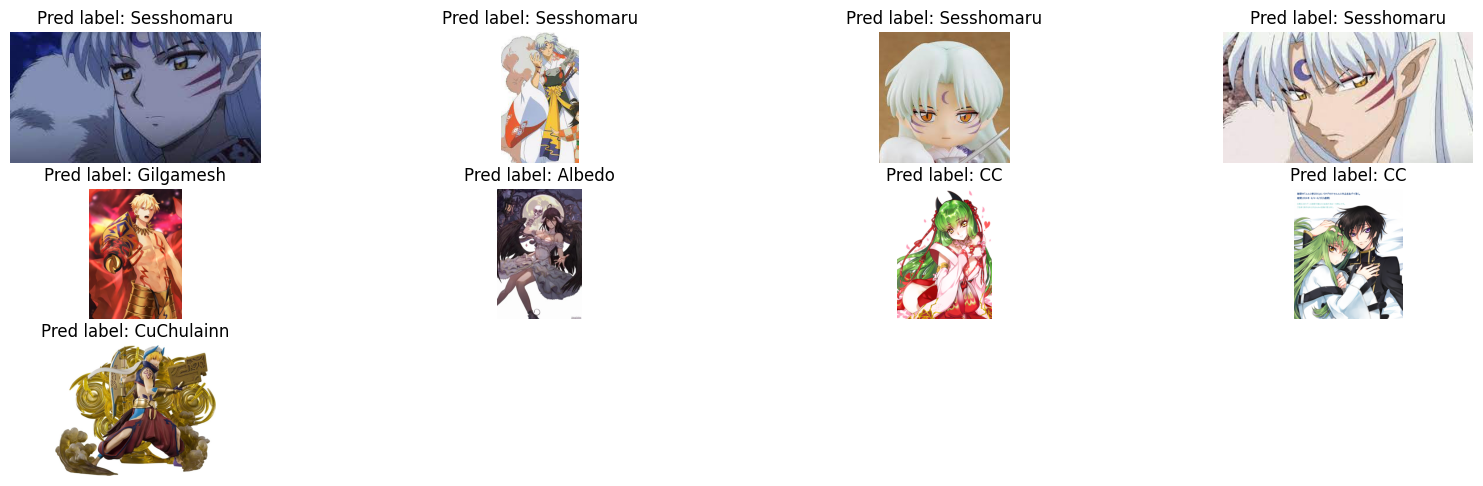

In [29]:
plt.figure(figsize=[20,20])    
count1=1
for i in os.listdir(r'prediction'):
        custom_image = r'prediction'+'/'+ i
        img = torchvision.io.read_image(custom_image)
        plt.subplot(10,4,count1)
        plt.imshow(img.permute(1, 2, 0))
        plt.title(f"Pred label: {img_pre_labels[count1-1]}")
        plt.axis(False)
        count1+=1